# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)

## Подготовка данных

### Анализ данных

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

import time
from IPython.display import display
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


16 колонок и 354369 строк. В данных есть пропуски. Посмотрим первые 5 строк в таблице

In [3]:
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В данных есть количественные признаки, категориальные и колонки с датой. 

Посмотрим на пропуски в процентном соотношении

In [4]:
print(df.isna().sum()/len(df)*100)

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
NotRepaired          20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64


Довольно много пропусков в колонках **NotRepaired**(20%), **VehicleType**(10.6%), **FuelType**(9.3%)  и также немного пропусков в колонках **Gearbox** и **Model** (по 5.6%)


### Предобработка данных

Проверим есть ли дубликаты

In [5]:
print ('Количество дубликатов:', sum(df.duplicated()))

Количество дубликатов: 4


Всего 4 строки, удалим эти строки из данных

In [6]:
df=df.drop_duplicates()
print ('Количество дубликатов:', sum(df.duplicated()))

Количество дубликатов: 0


Дубликаты удалены.

Проверим есть ли аномалии в категориальных признаках. 

In [7]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [8]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [9]:
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [10]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [11]:
df['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [12]:
df['NotRepaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Аномалий нет, есть только пропуски - nan. 

Колонка **Model** оказывает влияние на цену, но заполнить корректно пропуски невозможно, тк у каждого бренда больше 1 модели машины. Так как пропусков всего 5,6%, то удалим их из данных.

In [13]:
df= df.loc[~df['Model'].isna()]

Данные по типу кузова в колонке **VehicleType** можно восстановить по модели, используя наиболее частые значения в одной и той же модели. 

In [14]:
df['VehicleType']=df['VehicleType'].fillna(df.groupby('Model')['VehicleType'].transform(lambda x: x.value_counts().idxmax()))
print(sum(df['VehicleType'].isna()))

0


По такому же принципу заполним пропуски в колонках **FuelType** и **Gearbox** 

In [15]:
df['Gearbox']=df['Gearbox'].fillna(df.groupby('Model')['Gearbox'].transform(lambda x: x.value_counts().idxmax()))
print(sum(df['Gearbox'].isna()))

0


In [16]:
df['FuelType']=df['FuelType'].fillna(df.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().idxmax()))
print(sum(df['FuelType'].isna()))

0


В колонке **NotRepaired** пропуски заполнить корректно не получится. Люди могут не заполнять эту колонку потому что машина не попадала в аварию\не чинилась и поэтому они не считают нужным заполнять это поле, или потому что была в аварии, но они хотят это скрыть.
Поэтому заполним пропуски значением unknown.

In [17]:
df['NotRepaired']=df['NotRepaired'].fillna('unknown')

Проверим остались ли пропуски.

In [18]:
print(df.isna().sum()/len(df)*100)

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
NotRepaired          0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64


Пропусков не осталось. Теперь рассмотрим аномальные данные в количественных признаках.


In [19]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,334660.000000,334660.000000,334660.000000,334660.000000,334660.000000,334660.0,334660.000000
mean,4504.372249,2003.924024,111.372659,128562.795076,5.806075,0.0,50671.327365
std,4531.457109,69.377633,185.157391,37205.638630,3.689157,0.0,25754.527341
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1150.000000,1999.000000,70.000000,125000.000000,3.000000,0.0,30419.000000
50%,2800.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49525.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71229.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Есть нулевые данные в колонках **Price, Power, RegistrationMonth**. Есть также аномалные данные: максимальный год регистрации **RegistrationYear** =9999, минимальный год регистрации **RegistrationYear** =1000, максимальная мощность **Power** =20000. 

В колонке **NumberOfPictures** нет значений, поэтому она не будет полезна для обучения моделей. Колонка **PostalCode**  также не несет в себе полезной информации и на цену не влияет. Возраст автомобиля обычно определяют по году регистрации, поэтому месяц регистрации **RegistrationMonth** не является определяющим в цене. 
Эти 3 колонки можно удалить

In [20]:
df=df.drop(['NumberOfPictures', 'PostalCode','RegistrationMonth'], axis = 1)

Посмотрим количество строк с нулевой ценой

In [21]:
print('Количество строк с нулевой ценой: ',len(df.loc[df['Price']==0]))
print('Процент строк с нулевой ценой от общего количества: ', len(df.loc[df['Price']==0])/len(df)*100)

Количество строк с нулевой ценой:  8588
Процент строк с нулевой ценой от общего количества:  2.5661865774218606


Причина, по которой цена не была указана, не известна. Возможно, продавец забыл указать или , возможно, была ошибка при выгрузке данных.
Цена будет целевым признаком в модели, поэтому удалим эти строки чтобы не портить  модель. И посмотрим на распределение данных на гистограмме. 

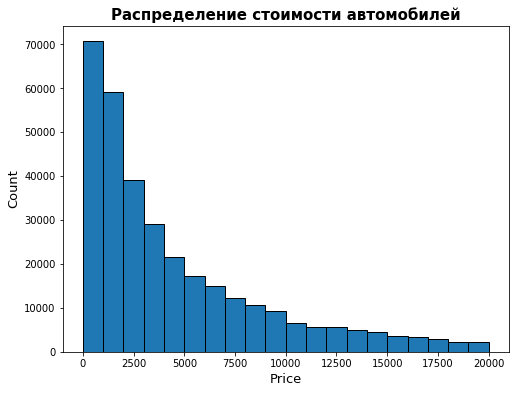

In [22]:
df=df.loc[df['Price']!=0]
df['Price'].hist(bins=20, figsize=(8,6), ec='black', grid=False)
plt.xlabel('Price', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('Распределение стоимости автомобилей', fontsize=15, fontweight='bold')
plt.show()

Количество объявлений снижается по мере роста цены. 

Мощность в колонке **Power** больше 1000 л.с. является аномальной. Заменим аномальные значения медианными по модели автомобиля.

In [23]:
df.loc[(df['Power']>1000) | (df['Power']==0), 'Power']= None
df['Power']=df['Power'].fillna(df.groupby('Model')['Power'].transform('median'))
print(sum(df['Power'].isna()))

1


Осталась 1 строка не заполненная. Удалим ее и посмотрим на распределение мощности на гистограмме

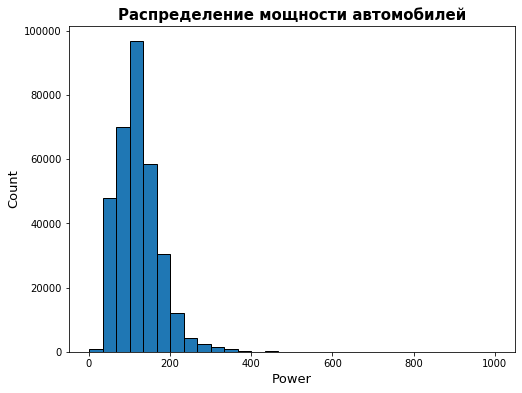

In [24]:
df=df.loc[~df['Power'].isna()]
df['Power'].hist(bins=30, figsize=(8,6), ec='black', grid=False)
plt.xlabel('Power', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('Распределение мощности автомобилей', fontsize=15, fontweight='bold')
plt.show()

Посмотрим на разброс данных в колонке год регистрации - **RegistrationYear**

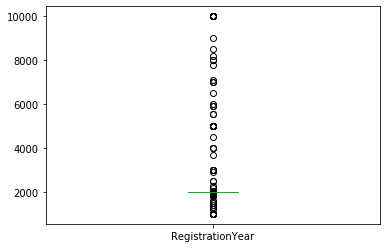

In [25]:
df['RegistrationYear'].plot.box()
plt.show()

В данных очень много выбросов: значения от 1000 до 9999 гг. Попробуем определить нижнюю и верхнюю границу даты.

Посмотрим когда создали самую последнюю анкету.

In [26]:
date = pd.to_datetime(df['DateCreated'])
date.max()

Timestamp('2016-04-07 00:00:00')

Самая поздняя дата анкеты - 2016 год, значит дата регистрации автомобиля не может быть после 2016 года. Это верхняя граница 

Номерные знаки на автомобилях начали ставить с 1901 года. Пусть это будет нижняя граница.
Посмотрим на распредение в этих границах. 

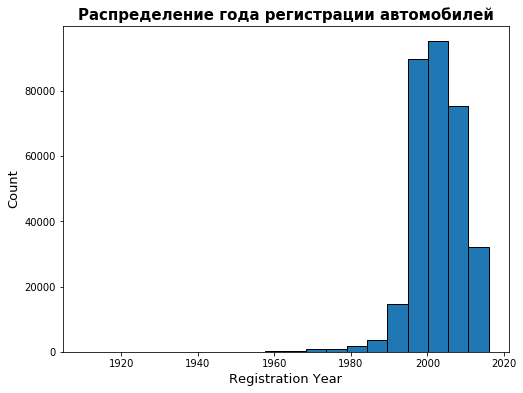

In [27]:
df=df.loc[(df['RegistrationYear']>=1901) & (df['RegistrationYear']<=2016)]
df['RegistrationYear'].hist(bins=20, figsize=(8,6), ec='black', grid=False)
plt.xlabel('Registration Year', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('Распределение года регистрации автомобилей', fontsize=15, fontweight='bold')
plt.show()


Из гистограммы видно, что нижнюю границу следует взять с 1960 года. 

In [28]:
df=df.loc[(df['RegistrationYear']>=1960) & (df['RegistrationYear']<=2016)]
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,101.0,golf,150000,petrol,volkswagen,unknown,2016-03-24 00:00:00,2016-04-07 03:16:57
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown,2016-03-14 00:00:00,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,2016-03-31 00:00:00,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes,2016-04-04 00:00:00,2016-04-06 19:17:07


Колонки дата создания анкеты **DateCreated**, дата скачивания анкеты **DateCrawled** и дата последней активности пользователя **LastSeen** на цену автомобилей не влияют. Поэтому удалим эти 3 колонки

In [29]:
df=df.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
display(df.head())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,101.0,golf,150000,petrol,volkswagen,unknown
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes


Проверим сколько данных было удалено. 

In [30]:
df.shape

(313954, 10)

In [31]:
print('Удалено: {:.2%}'.format((354369-313954)/354369))

Удалено: 11.40%


Удалено только 11% данных. 

### Кодирование категориальных признаков

Для модели CatBoost кодирование не нужно. Поэтому создадим для нее таблицу с признаками и целевой признак из оригинальных данных и разделим выборку на обучающую и тестовую в соотношении 75:25.

In [32]:
target=df['Price']
features=df.drop('Price', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
        features,target, test_size=0.25, random_state=12345)

In [33]:
print('Обучающая выборка: ', features_train.shape,  target_train.shape)
print('Тестовая выборка: ', features_test.shape,  target_test.shape)

Обучающая выборка:  (235465, 9) (235465,)
Тестовая выборка:  (78489, 9) (78489,)


Резделение получилось корректным

Для более простых моделей используем кодирование OHE, затем создадим для них таблицу с признаками и целевой признак и разделим выборку на обучающую и тестовую в соотношении 75:25.

In [34]:
df_ohe = pd.get_dummies(df, drop_first=True)
display(df_ohe.head(3))

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,...,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,480,1993,101.0,150000,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,9800,2004,163.0,125000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75.0,150000,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [35]:
target_ohe=df_ohe['Price']
features_ohe=df_ohe.drop('Price', axis=1)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
        features_ohe,target_ohe, test_size=0.25, random_state=12345)

In [36]:
print('Обучающая выборка: ', features_train_ohe.shape,  target_train_ohe.shape)
print('Тестовая выборка: ', features_test_ohe.shape,  target_test_ohe.shape)

Обучающая выборка:  (235465, 305) (235465,)
Тестовая выборка:  (78489, 305) (78489,)


Резделение получилось корректным

**Выводы**

Данные загружены и проверены. Дубликаты удалены. Часть пропусков и аномальных значений заполнены и заменены на основе имеющихся данных. Остальная часть удалена. Всего удалено 11% данных. 

Для простых моделей категориальные признаки преобразованы с помощью one-hot encoding. Данные разделены на обучающую и тестовую выборки в соотношении 75:25

## Обучение моделей

Сначала создадим константную модель, которая любому объекту будет предсказывать среднее значение и посчитаем для нее метрику RMSE. С этой метрикой будем сравнивать все последующие модели 

In [37]:
predicted_const = pd.Series(target_test.mean(), index=target_test.index)
rmse_const= mean_squared_error(target_test,predicted_const)**0.5
print('RMSE константной модели: {:.2f}'. format(rmse_const))

RMSE константной модели: 4551.94


Возьмем для обучения и анализа 4 модели: Логистическая регрессия, Решающее дерево, CatBoost и  LightGBM

Напишем функцию для кроссвалидации, поиска оптимальных параметров и расчета RMSE по этим параметрам на обучающей выборке для простых моделей.

In [38]:
def calc(model, features, target, params):
    grid= GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=5, n_jobs = -1)
    grid.fit(features, target)
    rmse=(-grid.best_score_)**0.5
    print('RMSE модели на обучающей выборке:{:.2f}'.format(rmse))
    print('Лучшие гиперпараметры для модели: ', grid.best_params_)

**Линейная регрессия**

In [39]:
%%time
line=LinearRegression()
line_params={'normalize':[True,False], 'copy_X':[True, False]}
calc(line, features_train_ohe, target_train_ohe,line_params )

RMSE модели на обучающей выборке:2635.72
Лучшие гиперпараметры для модели:  {'copy_X': True, 'normalize': False}
CPU times: user 5min 29s, sys: 1min 37s, total: 7min 6s
Wall time: 7min 7s


RMSE на обучающей выборке с параметрами {'copy_X': True, 'normalize': False} получилось 2635.72, что меньше чем значение константной модели. На кроссвалидацию ушло около 7 минут. 

Обучим модель с найденными параметрами  на тестовой выборке и измерим время обучения и предсказания

In [40]:
%%time
line_test= LinearRegression(copy_X= True, normalize= False)
line_test.fit(features_train_ohe, target_train_ohe)

CPU times: user 19.1 s, sys: 5.75 s, total: 24.8 s
Wall time: 25 s


LinearRegression()

In [41]:
%%time
predictions_line=line_test.predict(features_test_ohe)

CPU times: user 85.1 ms, sys: 82.6 ms, total: 168 ms
Wall time: 185 ms


In [42]:
mse = mean_squared_error(target_test_ohe,predictions_line)
print('RMSE для Линейной регресии на тестовой выборке: {:.2f}'.format( (mse.mean()**0.5)))

RMSE для Линейной регресии на тестовой выборке: 2672.75


**Решающее дерево**

In [43]:
%%time
tree= DecisionTreeRegressor(random_state=12345)
tree_params = {'max_depth': range(1, 21, 5), 'splitter': ['best', 'random']}
calc(tree, features_train_ohe, target_train_ohe, tree_params )

RMSE модели на обучающей выборке:1861.24
Лучшие гиперпараметры для модели:  {'max_depth': 16, 'splitter': 'best'}
CPU times: user 2min 45s, sys: 7.59 s, total: 2min 53s
Wall time: 2min 55s


RMSE на обучающей выборке с параметрами {'max_depth': 16, 'splitter': 'best'} получилось 1861.24, что меньше чем значение константной модели и лучше чем у Линейной регрессии. На кроссвалидацию ушло около 3 минут. 

Обучим модель с найденными параметрами на тестовой выборке и измерим время обучения и предсказания

In [44]:
%%time
tree_test= DecisionTreeRegressor(random_state=12345, max_depth=16)
tree_test.fit(features_train_ohe, target_train_ohe)

CPU times: user 7.89 s, sys: 96.1 ms, total: 7.99 s
Wall time: 8.02 s


DecisionTreeRegressor(max_depth=16, random_state=12345)

In [45]:
%%time
predictions_tree=tree_test.predict(features_test_ohe)

CPU times: user 105 ms, sys: 62.9 ms, total: 168 ms
Wall time: 173 ms


In [46]:
mse = mean_squared_error(target_test_ohe,predictions_tree)
print('RMSE для Решающего дерева на тестовой выборке: {:.2f}'.format((mse.mean()**0.5)))

RMSE для Решающего дерева на тестовой выборке: 1859.89


**CatBoost**

Создадим список категориальных признаков

In [47]:
cat_features = ['VehicleType','Gearbox', 'Model', 'FuelType','Brand','NotRepaired']

С помощью кроссвалидации найдем лучшие параметры и метрику RMSE на обучающей выборке с этими параметрами

In [48]:
%%time
cat = CatBoostRegressor(iterations=100, verbose=False,cat_features = cat_features)
cat_params = {'learning_rate':[0.1, 0.3, 0.5], 'depth':[5,10, 15]} 
cat_grid= GridSearchCV(cat, cat_params, scoring='neg_mean_squared_error',  cv=3, n_jobs = -1)
cat_grid.fit(features, target)
rmse=(-cat_grid.best_score_)**0.5
print('RMSE модели CatBoost на обучающей выборке:{:.2f}'.format(rmse))
print('Лучшие гиперпараметры для модели: ', cat_grid.best_params_)

RMSE модели CatBoost на обучающей выборке:1585.19
Лучшие гиперпараметры для модели:  {'depth': 15, 'learning_rate': 0.3}
CPU times: user 34min 38s, sys: 4min 17s, total: 38min 55s
Wall time: 39min 43s


RMSE на обучающей выборке с параметрами {'depth': 15, 'learning_rate': 0.3} получилось 1585.19, что меньше чем значение константной модели и меньше чем у простых моделей. На кроссвалидацию ушло около 40 минут.

Обучим модель с найденными параметрами на тестовой выборке и измерим время обучения и предсказания

In [49]:
%%time
cat_test = CatBoostRegressor(iterations=100, verbose=False,cat_features = cat_features, 
                        learning_rate=0.3,depth=15, random_state=12345 )
cat_test.fit(features_train, target_train)

CPU times: user 2min 30s, sys: 20.3 s, total: 2min 51s
Wall time: 2min 53s


In [50]:
%%time
predictions_cat=cat_test.predict(features_test)

CPU times: user 424 ms, sys: 16.1 ms, total: 440 ms
Wall time: 384 ms


In [51]:
mse = mean_squared_error(target_test,predictions_cat)
print('RMSE для CatBoost на тестовой выборке: {:.2f}'.format((mse.mean()**0.5)))

RMSE для CatBoost на тестовой выборке: 1591.12


 **LightGBM**

Поменяем тип категориальных признаков на 'category'

In [52]:
df[['VehicleType','Gearbox', 'Model', 'FuelType','Brand','NotRepaired']]= df[['VehicleType',
            'Gearbox', 'Model', 'FuelType','Brand','NotRepaired']].astype('category')


После изменения типа затем создадим таблицу с признаками и целевой признак и разделим выборку на обучающую и тестовую в соотношении 75:25.

In [53]:
target_lgb=df['Price']
features_lgb=df.drop('Price', axis=1)
features_train_lgb, features_test_lgb, target_train_lgb, target_test_lgb = train_test_split(
        features_lgb,target_lgb, test_size=0.25, random_state=12345)

In [54]:
%%time
categorial_features = ['VehicleType','Gearbox', 'Model', 'FuelType','Brand','NotRepaired']
lgb=LGBMRegressor(num_iteration=100, verbose=0, random_state=12345, categorial_features=categorial_features)
lgb_params = {'learning_rate':[0.1, 0.3, 0.5], 'depth':[5,10, 15],'boosting_type':['gbdt', 'dart', 'goss']}
lgb_grid= GridSearchCV(lgb, lgb_params, scoring='neg_mean_squared_error',  cv=3, n_jobs = -1)
lgb_grid.fit(features_lgb, target_lgb)
rmse=(-lgb_grid.best_score_)**0.5
print('RMSE модели LightGBM на обучающей выборке:{:.2f}'.format(rmse))
print('Лучшие гиперпараметры для модели: ',lgb_grid.best_params_)

RMSE модели LightGBM на обучающей выборке:1587.51
Лучшие гиперпараметры для модели:  {'boosting_type': 'dart', 'depth': 5, 'learning_rate': 0.5}
CPU times: user 19min, sys: 1.19 s, total: 19min 1s
Wall time: 19min 12s


RMSE на обучающей выборке с параметрами {'boosting_type': 'dart', 'depth': 5, 'learning_rate': 0.5} получилось 1587.51, что меньше чем значение константной модели и меньше чем у простых моделей. На кроссвалидацию ушло около 20 минут.

Обучим модель с найденными параметрами на тестовой выборке и измерим время обучения и предсказания

In [55]:
%%time
lgb_test = LGBMRegressor(iterations=100, verbose=0,categorial_features=categorial_features, 
                        learning_rate=0.5,depth=5, random_state=12345, boosting_type='dart')
lgb_test.fit(features_train_lgb, target_train_lgb)

CPU times: user 27.1 s, sys: 14.7 ms, total: 27.1 s
Wall time: 27.4 s


LGBMRegressor(boosting_type='dart',
              categorial_features=['VehicleType', 'Gearbox', 'Model',
                                   'FuelType', 'Brand', 'NotRepaired'],
              depth=5, iterations=100, learning_rate=0.5, random_state=12345,
              verbose=0)

In [56]:
%%time
predictions_lgb=lgb_test.predict(features_test_lgb)

CPU times: user 1.1 s, sys: 0 ns, total: 1.1 s
Wall time: 1.1 s


In [57]:
mse = mean_squared_error(target_test_lgb,predictions_lgb)
print('RMSE для модели LGBM на тестовой выборке: {:.2f}'.format((mse.mean()**0.5)))

RMSE для модели LGBM на тестовой выборке: 1612.62


**Вывод**

С помощью кроссвалидации найдены лучшие параметры, с которыми обучены 4 модели: Логистическая регрессия, Решающее дерево, CatBoost и LightGBM. Метрика RMSE у всех моделей оказалась лучше, чем у константной модели. 

## Анализ моделей

Посмотрим на показатели моделей в таблице

In [59]:
data={'Модель': ['Linear Regression', 'DecisionTree', 'CatBoost', 'LightGBM'], 'RMSE на тесте': [2672.75, 1859.89, 1591.12, 1612.62 ],
     'Время обучения модели':['25 s' , '8.02 s' , '2min 53', '27.4 s' ],'Время предсказания модели' : ['185 ms', '173 ms', '384 ms', '1.1 s']}
data_pivot=pd.DataFrame.from_dict(data)
display(data_pivot)

,Модель,RMSE на тесте,Время обучения модели,Время предсказания модели
0,Linear Regression,2672.75,25 s,185 ms
1,DecisionTree,1859.89,8.02 s,173 ms
2,CatBoost,1591.12,2min 53,384 ms
3,LightGBM,1612.62,27.4 s,1.1 s


**Выводы**

Однозначно лучшей модели, которая бы превосходила другие по всем трем параметрам, нет. 

Из простых моделей быстрее всего обучается, предсказывает и показывает неплохую метрику RMSE модель Дерево решений. Эта модель подойдет, если нужен простой и быстрый алгоритм с приемлемой точностью. 

У моделей градиентного бустинга метрика RMSE лучше, но время обучения и предсказания выше, чем у Дерева решений. 
У модели CatBoost метрика RMSE незначительно лучше, чем у модели LightGBM. Но при этом обучается модель в 5 раза дольше, а предсказывает в 3 раза быстрее. Если время обучения более важно, чем время предсказания, то следует выбрать модель LightGBM. Если важнее скорость предсказания, то модель CatBoost.